# Example for making plots from processor output

This example takes the output of the forward_jet processor, but should be rather general.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from coffea import util, hist
from coffea.processor import accumulate

In [3]:
from Tools.config_helpers import loadConfig, make_small, data_pattern, get_latest_output, load_yaml, data_path
from Tools.helpers import get_samples
#from plots.helpers import scale_and_merge

In [17]:
year = 2018
era = ''
ul = f"UL{str(year)[2:]}{era}"
cfg = loadConfig()

samples = get_samples(f"samples_{ul}.yaml")
mapping = load_yaml(data_path+"nano_mapping.yaml")

renorm   = {}

data = ['SingleMuon', 'DoubleMuon', 'EGamma', 'MuonEG']
order = ['topW', 'diboson', 'TTW', 'TTH', 'DY', 'top', 'XG']

datasets = data + order

In [18]:
outputs = []

for sample in datasets:
    cache_name = f'OS_analysis_{sample}_{year}{era}'
    outputs.append(get_latest_output(cache_name, cfg))
    
    # NOTE we could also rescale processes here?

    for dataset in mapping[ul][sample]:
        if samples[dataset]['reweight'] == 1:
            renorm[dataset] = 1
        else:
            # Currently only supporting a single reweight.
            weight, index = samples[dataset]['reweight'].split(',')
            index = int(index)
            renorm[dataset] = samples[dataset]['sumWeight']/samples[dataset][weight][index]  # NOTE: needs to be divided out
        try:
            renorm[dataset] = (samples[dataset]['xsec']*1000*cfg['lumi'][year]/samples[dataset]['sumWeight'])*renorm[dataset]
        except:
            renorm[dataset] = 1
output = accumulate(outputs)
    

Found the following cache: /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/outputs/OS_analysis_SingleMuon_2018_20220411_094803.coffea
Found the following cache: /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/outputs/OS_analysis_DoubleMuon_2018_20220411_093517.coffea
Found the following cache: /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/outputs/OS_analysis_EGamma_2018_20220411_094325.coffea
Found the following cache: /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/outputs/OS_analysis_MuonEG_2018_20220411_094212.coffea
Found the following cache: /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/outputs/OS_analysis_topW_2018_20220411_144733.coffea
Found the following cache: /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/outputs/OS_analysis_diboson_2018_20220411_110939.coffea
Found the following cache: /home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/outputs/OS_analysis_TTW_2018_20220411_103009.coffea
Found the following cache: /ho

In [29]:
cfg['lumi']

{'2016APV': 19.5, 2016: 16.8, 2017: 41.48, 2018: 59.83}

In [19]:
def scale_and_merge(histogram, scales, nano_mapping):
    """
    Scale NanoAOD samples to a physical cross section.
    Merge NanoAOD samples into categories, e.g. several ttZ samples into one ttZ category.
    
    histogram -- coffea histogram
    scales -- scales to apply to each dataset
    nano_mapping -- dictionary to map NanoAOD samples into categories
    """
    temp = histogram.copy()

    temp.scale(scales, axis='dataset')
    temp = temp.group("dataset", hist.Cat("dataset", "new grouped dataset"), nano_mapping) # this is not in place
                
    return temp

res = scale_and_merge(output['N_jet'], renorm, mapping[ul])

/home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/coffea/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f01b317e760>
  warnings.warn(


In [20]:
output_scaled = {}
for key in output.keys():
    if isinstance(output[key], hist.Hist):
        #print (key)
        try:
            output_scaled[key] = scale_and_merge(output[key], renorm, mapping[ul])
        except:
            print ("At least I tried.")

/home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/coffea/coffea/hist/hist_tools.py:376: RuntimeWarning: Not all requested indices present in <Cat (name=dataset) instance at 0x7f02b87d66a0>
  warnings.warn(


At least I tried.


In [21]:
res.values();

In [22]:
N_bins = hist.Bin('multiplicity', r'$N$', 10, -0.5, 9.5)

my_labels = {
    'topW': 'top-W scat.',
    'TTZ': r'$t\bar{t}Z$',
    'TTXnoW': r'$t\bar{t}X\ (no\ W)$',
    'TTW': r'$t\bar{t}W$',
    'TTH': r'$t\bar{t}H$',
    'diboson': 'VV/VVV',
    'rare': 'rare',
    'top': r'$t\bar{t}$',
    'XG': 'XG',  # this is bare XG
    'DY': 'Drell-Yan',  # this is bare XG
    'conv_mc': 'conversion',
    'np_obs_mc': 'nonprompt (MC true)',
    'np_est_mc': 'nonprompt (MC est)',
    'cf_obs_mc': 'charge flip (MC true)',
    'cf_est_mc': 'charge flip (MC est)',
    'np_est_data': 'nonprompt (est)',
    'cf_est_data': 'charge flip (est)',
}

my_colors = {
    'topW': '#FF595E',
    'TTZ': '#FFCA3A',
    'TTXnoW': '#FFCA3A',
    'TTW': '#8AC926',
    'TTH': '#34623F',
    'diboson': '#525B76',
    'rare': '#EE82EE',
    'top': '#1982C4',
    'XG': '#5bc0de',
    'conv_mc': '#5bc0de',
    'DY': '#6A4C93',
    'np_obs_mc': '#1982C4',
    'np_est_mc': '#1982C4',
    'np_est_data': '#1982C4',
    'cf_obs_mc': '#0F7173',
    'cf_est_mc': '#0F7173',
    'cf_est_data': '#0F7173',
}

all_processes = [ x[0] for x in output_scaled['N_jet'].values().keys() ]
signals = []
omit    = [ x for x in all_processes if (x not in signals and x not in order and x not in data) ]



In [27]:
output_scaled['N_jet'].integrate('n_ele').values();

In [28]:
output_scaled['N_jet'].integrate('systematic', 'central').integrate('n_ele').values();

Data: 217799.0 MC: 226705.11


/home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/coffea/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/coffea/coffea/hist/plot.py:439: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw
/home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:352: RuntimeWarning: invalid value encountered in true_divide
  up = np.ones_like(central) + np.sqrt(up)/central
/home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:353: RuntimeWarning: invalid value encountered in true_divide
  down = np.ones_like(central) - np.sqrt(down)/central


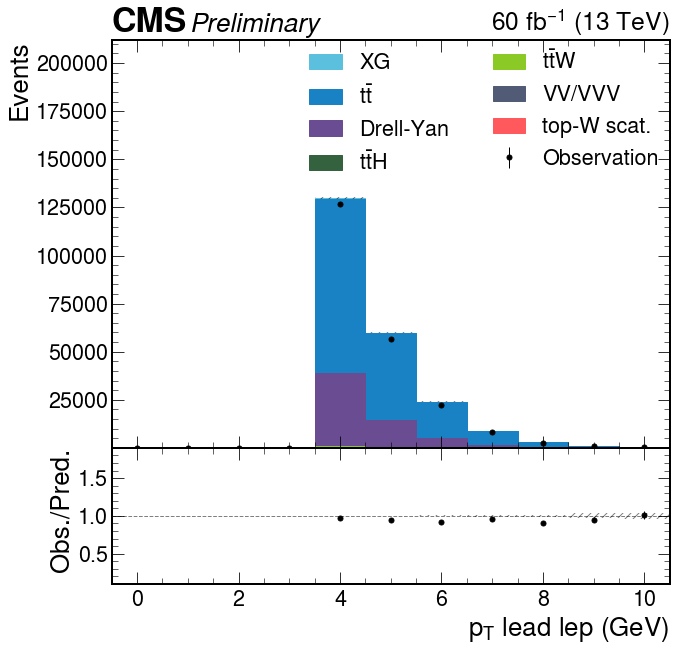

In [25]:
from plots.helpers import makePlot

makePlot(output_scaled,
         'N_jet', 'multiplicity',
         data=data,
         bins=N_bins, log=False, normalize=False, axis_label=r'$p_{T}\ lead \ lep\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         order=order,
         omit=omit,
         signals=signals,
         lumi=60,
         #save=os.path.expandvars(plot_dir+'lead_lep_pt')
         )


Data: 509459.0 MC: 515274.01


/home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/coffea/coffea/hist/plot.py:427: RuntimeWarning: invalid value encountered in true_divide
  rsumw = sumw_num / sumw_denom
/home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/coffea/coffea/hist/plot.py:439: RuntimeWarning: invalid value encountered in true_divide
  poisson_interval(rsumw, sumw2_num / sumw_denom**2) - rsumw
/home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:352: RuntimeWarning: invalid value encountered in true_divide
  up = np.ones_like(central) + np.sqrt(up)/central
/home/users/dspitzba/TOP/CMSSW_10_2_9/src/tW_scattering/plots/helpers.py:353: RuntimeWarning: invalid value encountered in true_divide
  down = np.ones_like(central) - np.sqrt(down)/central


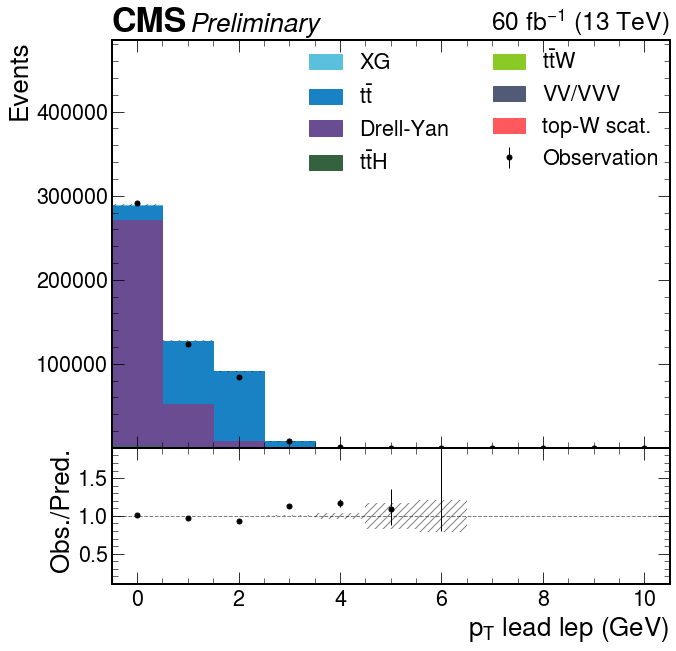

In [26]:
from plots.helpers import makePlot

makePlot(output_scaled,
         'N_b', 'multiplicity',
         data=data,
         bins=N_bins, log=False, normalize=False, axis_label=r'$p_{T}\ lead \ lep\ (GeV)$',
         new_colors=my_colors, new_labels=my_labels,
         order=order,
         omit=omit,
         signals=signals,
         lumi=60,
         #upHists=['jes_up', 'PU_up', 'b_up', 'l_up'],
         #downHists=['jes_down', 'PU_down', 'b_down', 'l_down'],
         #save=os.path.expandvars(plot_dir+'lead_lep_pt')
         )

## Root export

In [48]:
output['lead_lep'].integrate('eta').integrate('systematic', 'central').integrate('n_ele').integrate('dataset').values(overflow='all')[()][101]

25390.50480307131

In [40]:
import uproot

In [42]:
outputFile = uproot.recreate("test.root")

h_MC = output['lead_lep'].integrate('eta').integrate('systematic', 'central').integrate('n_ele').integrate('dataset')

outputFile["data_obs"] = h_MC.to_hist() # this does include the over/underflow as separate bins

## Cutflow example

In [29]:
# Scale the cutflow output. This should be packed into a function?
cutflow_output = {}

for sample in datasets:
   
    # NOTE we could also rescale processes here?
    for dataset in mapping[ul][sample]:

        cutflow_output[sample] = {}
        dataset_0 = mapping[ul][sample][0]

        #print ("Scaling to {}/fb".format(cfg['lumi'][year]))
        #for dataset in mapping[ul][sample]:
        #    print ("Sample {}".format(dataset))
        #    print ("sigma*BR: {}".format(float(samples[dataset]['xsec']) * cfg['lumi'][year] * 1000))

        for key in output[dataset_0]:
            cutflow_output[sample][key] = 0.
            for dataset in mapping[ul][sample]:
                cutflow_output[sample][key] += (renorm[dataset]*output[dataset][key] * float(samples[dataset]['xsec']) * cfg['lumi'][year] * 1000 / float(samples[dataset]['sumWeight']))




In [32]:
from Tools.helpers import getCutFlowTable
processes = ['topW', 'DY', 'top']
lines= [
        'filter',
        'dilep',
        'p_T(lep0)>25',
        'p_T(lep1)>20',
        'trigger',
        'OS',
        'N_jet>3',
        'N_central>2',
        'N_btag>0',
        'N_light>0',
        'MET>30',
        'N_fwd>0',
        'min_mll'
    ]

getCutFlowTable(cutflow_output,
                       processes=processes,
                       lines=lines,
                       significantFigures=3,
                       absolute=True,
                       #signal='topW_v3',
                       total=False,
                       )

,topW,DY,top
filter,949.0 +/- 52.0,20600000000.0 +/- 0.0,153000.0 +/- 25000.0
dilep,639.0 +/- 42.0,10100000000.0 +/- 0.0,72500.0 +/- 15500.0
p_T(lep0)>25,638.0 +/- 42.0,9850000000.0 +/- 0.0,72100.0 +/- 15500.0
p_T(lep1)>20,629.0 +/- 42.0,9470000000.0 +/- 0.0,69000.0 +/- 15200.0
trigger,628.0 +/- 42.0,9400000000.0 +/- 0.0,68700.0 +/- 15200.0
OS,596.0 +/- 41.0,9400000000.0 +/- 0.0,68700.0 +/- 15200.0
N_jet>3,588.0 +/- 40.0,188000000.0 +/- 0.0,45900.0 +/- 12700.0
N_central>2,586.0 +/- 40.0,132000000.0 +/- 0.0,44700.0 +/- 12500.0
N_btag>0,579.0 +/- 40.0,68600000.0 +/- 100000.0,44100.0 +/- 12400.0
N_light>0,579.0 +/- 40.0,68600000.0 +/- 100000.0,44100.0 +/- 12400.0


In [4]:
from Tools.helpers import getCutFlowTable

processes = [
    'topW_v3',
    'TTW', 'TTZ', 'TTH', 'ttbar',
]
lines = ['entry']
lines += ['lepveto', 'dilep', 'SS', 'filter', 'p_T(lep0)>25', 'p_T(lep1)>20', ]
lines += ['N_jet>3', 'N_central>2', 'N_btag>0', 'N_fwd>0', 'N_jet>4', 'N_central>3', 'ST', 'MET>50', 'delta_eta', 'fwd_p>500', 'p_T(lep0)>40', 'p_T(lep1)>30']
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, signal='topW_v3')
df


,topW_v3,TTW,TTZ,TTH,ttbar,S/B
entry,226.3 +/- 0.2,15200.0 +/- 30.0,12400.0 +/- 10.0,11630.0 +/- 10.0,11590000.0 +/- 0.0,0.0000
lepveto,119.7 +/- 0.2,3747.0 +/- 13.0,5268.0 +/- 6.0,2739.0 +/- 3.0,2647000.0 +/- 1000.0,0.0000
dilep,46.45 +/- 0.11,1319.0 +/- 7.0,2391.0 +/- 4.0,811.0 +/- 1.7,834000.0 +/- 300.0,0.0001
SS,35.18 +/- 0.09,433.9 +/- 2.0,151.0 +/- 0.9,209.4 +/- 0.8,1860.0 +/- 23.0,0.0133
filter,35.14 +/- 0.09,433.5 +/- 2.0,150.8 +/- 0.9,209.2 +/- 0.8,1859.0 +/- 23.0,0.0132
p_T(lep0)>25,34.74 +/- 0.09,429.1 +/- 2.0,148.2 +/- 0.9,205.1 +/- 0.8,1789.0 +/- 22.0,0.0135
p_T(lep1)>20,31.82 +/- 0.09,391.9 +/- 1.9,132.6 +/- 0.8,180.5 +/- 0.7,1418.0 +/- 18.0,0.0150
N_jet>3,28.48 +/- 0.08,262.5 +/- 1.6,87.75 +/- 0.69,133.1 +/- 0.6,566.8 +/- 10.9,0.0271
N_central>2,27.7 +/- 0.08,251.2 +/- 1.6,80.29 +/- 0.67,128.6 +/- 0.6,508.1 +/- 10.0,0.0286
N_btag>0,25.16 +/- 0.08,229.2 +/- 1.5,72.4 +/- 0.63,114.4 +/- 0.6,423.7 +/- 9.0,0.0300


In [11]:
df = getCutFlowTable(output, processes=processes, lines=lines, significantFigures=4, absolute=False, signal='topW_v3')
df

,topW_v3,TTW,TTZ,TTH,ttbar
entry,1.0000,1.0000,1.0000,1.0000,1.0000
lepveto,0.5287,0.2466,0.4247,0.2356,0.2283
dilep,0.3882,0.3520,0.4540,0.2961,0.3151
SS,0.7574,0.3290,0.0632,0.2582,0.0022
filter,0.9989,0.9991,0.9984,0.9988,0.9996
p_T(lep0)>25,0.9884,0.9897,0.9831,0.9803,0.9620
p_T(lep1)>20,0.9159,0.9135,0.8947,0.8801,0.7926
N_jet>3,0.8951,0.6696,0.6616,0.7372,0.3998
N_central>2,0.9725,0.9572,0.9149,0.9661,0.8966
N_btag>0,0.9083,0.9124,0.9018,0.8900,0.8338


## Plot example

We redefine a few axes to make plots with a more reasonable binning (remember that we chose to define histograms with a high number of bins, and then just rebin later - that later is now!).

